In [1]:
#!pip install Pillow
#!pip install fpdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

#załadowanie plików do odczytu przez windows explorer
import tkinter as tk
from tkinter import filedialog
import os
from pathlib import Path

#zapis do pdfu z listy figs
from matplotlib.backends.backend_pdf import PdfPages

In [9]:
#funckja usuwająca zbędne komórki w dataframe
def clean(df):
    df = df.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).reset_index(drop = True)
    return df
#funckja tworząca data frame
def make_df(file):
    df = pd.read_table(file,header = None)
    df = df.drop([0,1,2,3,4,5,6,7,10,15,16]).reset_index(drop = True)
    return df

#funckja wydobywa ze ścieżki do folderu numer próbki
def number(Hist_dir):
    counter=0
    lista=list()
    for i in str(Hist_dir):
        if i.isdigit() and counter<4:
            lista.append(i)
            counter+=1
    return "".join(lista)  

#funckja wyciąga ścięzke do pliku bez elementu WindowsPath gdy uzywamy import os oraz from pathlib import Path
def path(files):
    files2=list()
    for i in files:
        files2.append(str(i))
    return files2

#funckja zmieniająca kształt tabeli z trzech kolumn X Y Z na iloczyn X*Y bez powtorzen
def df_reshape(lista):
    columns = ["Axis X", "Axis Y", "Value"]
    a=pd.DataFrame(lista, columns=columns)
    X = a.iloc[:,0]
    Y = a.iloc[:,1]
    Z = a.iloc[:,2]
# Reshape data    
    df = pd.DataFrame(np.column_stack([X, Y, Z]), columns=list('XYZ'))
    df = df.pivot(index='Y', columns='X', values='Z')
    return df

In [3]:
#załadowanie plików do odczytu przez windows explorer

root = tk.Tk()
root.withdraw()

#files = filedialog.askopenfilenames() #otwiera bezpośrednio pliki
Hist_dir = filedialog.askdirectory()  #otwiera folder z plikami

files = path(sorted(Path(Hist_dir).iterdir(), key=os.path.getmtime))

In [4]:
#załadowane dane łączy w jeden DataFrame
df = pd.concat(list(pd.read_table(f,header = None) for f in files),axis=1)
#wyrzucenie zbędnych wierszy
df = df.drop([0,1,2,3,4,5,6,7,10,15,16]).reset_index(drop = True)
df

,0,1,0,1,0,1,0,1,0,1,...,0,1,0,1,0,1,0,1,0,1
0,X position (mm),0.000000,X position (mm),1.000000,X position (mm),2.000000,X position (mm),3.000000,X position (mm),4.000000,...,X position (mm),15.000000,X position (mm),16.000000,X position (mm),17.000000,X position (mm),18.000000,X position (mm),19.000000
1,Y position (mm),0.000000,Y position (mm),0.000000,Y position (mm),0.000000,Y position (mm),0.000000,Y position (mm),0.000000,...,Y position (mm),19.000000,Y position (mm),19.000000,Y position (mm),19.000000,Y position (mm),19.000000,Y position (mm),19.000000
2,Remanence (mdeg),19.915925,Remanence (mdeg),19.553404,Remanence (mdeg),17.348235,Remanence (mdeg),16.667412,Remanence (mdeg),16.269028,...,Remanence (mdeg),3.882027,Remanence (mdeg),16.945741,Remanence (mdeg),16.619854,Remanence (mdeg),16.258530,Remanence (mdeg),8.396725
3,Saturation (mdeg),25.679065,Saturation (mdeg),26.566430,Saturation (mdeg),22.505784,Saturation (mdeg),21.364323,Saturation (mdeg),21.748666,...,Saturation (mdeg),4.148164,Saturation (mdeg),9.687789,Saturation (mdeg),14.521388,Saturation (mdeg),15.606450,Saturation (mdeg),10.025648
4,Coercive field (Oe),539.646496,Coercive field (Oe),545.666918,Coercive field (Oe),539.716148,Coercive field (Oe),535.526212,Coercive field (Oe),547.269912,...,Coercive field (Oe),219.194167,Coercive field (Oe),5024.590000,Coercive field (Oe),5580.818315,Coercive field (Oe),3594.179894,Coercive field (Oe),4445.185885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,-10.585700,-26.727707,-10.590400,-28.548301,-10.564200,-24.907113,-10.565300,-22.072718,-10.575600,-22.476115,...,-10.539100,1.012473,-10.529900,4.049363,-10.518800,-8.706741,-10.541100,-13.363854,-10.530400,-7.087314
258,-10.759700,-27.131104,-10.733100,-28.548301,-10.740100,-24.907113,-10.741600,-22.476115,-10.721600,-22.476115,...,-10.713200,1.822452,-10.674900,5.264331,-10.690800,-8.706741,-10.682400,-13.363854,-10.693400,-6.682325
259,-10.898300,-27.131104,-10.899700,-27.741507,-10.906700,-24.498408,-10.912400,-22.879512,-10.894300,-22.476115,...,-10.847800,1.417463,-10.847100,6.884289,-10.860100,-9.111730,-10.848800,-11.743896,-10.834700,-5.872346
260,-11.055400,-27.943206,-11.041300,-26.526008,-11.048200,-24.907113,-11.048700,-23.288217,-11.061900,-22.879512,...,-11.008400,1.417463,-11.015700,6.479299,-10.995500,-8.706741,-10.984500,-11.338907,-10.995100,-5.467357


In [7]:
%%capture   
#funkcja magiczna nie pozwalająca wyświetlać outputu całej komórki. !!! ważne musi być zastosowana w pierwszej linii komórki
coercive=list()
remanence=list()
saturation=list()
mr_to_ms=list()
ncols=4
nrows=5
counter=0
Errors =list()
font=40
plt.rcParams["figure.figsize"] = (50,30)
for k in np.arange(math.ceil(len(files)/(ncols*nrows))):
    try:
    
        fig, ax = plt.subplots(nrows, ncols,constrained_layout=True)
#fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row')        
        for i in np.arange(nrows):
            for j in np.arange(ncols):
                df= make_df(files[counter])
                ax[i,j].plot(df.iloc[6:,0].astype(float),df.iloc[6:,1].astype(float),"r")
                ax[i,j].set_title(f"x = {float(df.iloc[0,1])} nm, y = {float(df.iloc[1,1])} nm",fontsize=font)
                ax[i,j].set_xlabel("H [kOe]",fontsize=font)
                ax[i,j].set_ylabel("Kerr signal [a.u.]",fontsize=font)
                ax[i,j].minorticks_on()
                ax[i,j].tick_params(axis="both", which = "major", length=20, direction ="in",labelsize=20)
                ax[i,j].tick_params(axis="both", which = "minor", length=10, direction ="in")
                counter += 1
                if df[6:].astype(float).sort_values(by=0, ascending=True).reset_index(drop=True).iloc[0,1]>0:
                    sign = -1
                else:
                    sign = 1
                coercive.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[4,1])*sign])
                remanence.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[2,1])])
                saturation.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[3,1])])
                mr_to_ms.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[2,1])/float(df.iloc[3,1])])
    except IndexError:
        Errors.append((i,j))
#zapis wszystkich plotow do listy. 1 element listy to wszystkie ploty dla danego k
figs = list(map(plt.figure, plt.get_fignums()))

In [5]:
#zapis do pdfu z listy figs

#pp = PdfPages('test.pdf')
pp = PdfPages(f'{number(files)}.pdf')
for image in figs:
    pp.savefig(image)
pp.close()

In [13]:
df_coercive = df_reshape(coercive)
df_remanence = df_reshape(remanence)
df_saturation = df_reshape(saturation)
df_mr_to_ms = df_reshape(mr_to_ms)

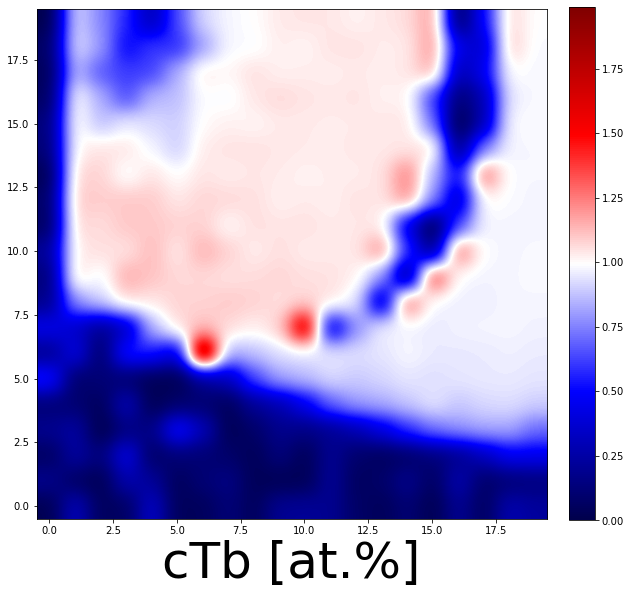

In [20]:
plt.imshow(df_mr_to_ms, cmap="seismic",interpolation='gaussian')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel("cTb [at.%]",fontsize=50)
plt.gca().invert_yaxis()  #odwraca oś Y
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [21]:
df_remanence

X,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
Y,,,,,,,,,,,,,,,,,,,,
0.0,2.085109,0.934135,0.133683,0.201699,1.148298,0.131184,0.140733,0.406051,0.144022,0.809448,0.538182,0.548177,0.258885,0.133050,0.415339,0.054295,0.607749,0.148127,1.084370,0.752948
1.0,1.048895,0.201699,0.063974,1.163280,0.746705,0.151603,0.438691,0.538419,0.110141,0.074079,0.112327,0.680393,0.208622,0.313849,0.733099,0.282509,1.495421,0.479910,0.809448,0.941092
2.0,0.267342,0.890404,0.460291,1.215499,0.208375,0.406051,0.406051,0.340743,0.127317,0.759525,0.179185,1.366407,0.742864,0.490943,0.883911,2.105503,3.421973,7.117144,11.758452,13.079897
3.0,1.181482,0.795558,0.000000,0.539239,0.557601,2.011063,1.480759,0.113215,0.659477,1.748287,1.844183,2.977899,5.272818,9.958163,17.078257,24.435024,30.230419,35.633816,39.436052,37.311004
4.0,1.734686,0.380819,0.137226,1.353072,0.069164,0.474145,0.692551,0.359857,2.696504,4.962765,10.412106,19.998785,27.537155,33.138251,40.350911,48.112586,50.894103,57.197937,63.336570,65.389236
5.0,16.045900,0.286399,0.541113,0.359276,0.125787,0.132586,2.250104,5.447116,14.327864,24.583058,31.897645,39.686837,43.051386,50.493872,56.978218,62.253447,70.260085,76.019194,82.611465,87.758279
6.0,8.977624,0.809448,0.177364,0.944534,0.730442,0.875215,8.575559,13.234729,27.921282,36.026390,42.889368,50.143527,54.800684,62.119351,72.219206,76.813477,83.305470,90.509554,97.797240,103.461511
7.0,15.898331,1.905737,0.892636,2.334041,9.912235,17.412420,23.563711,29.497352,35.308133,43.622027,42.115180,1.106104,2.971787,70.683334,79.652300,86.165041,95.502798,103.512174,110.272468,117.076890
8.0,7.624327,6.290304,9.917012,13.768577,16.881814,22.476115,27.400159,33.841038,40.202223,46.681600,55.702633,62.566348,5.176206,0.742421,10.814148,94.758493,103.006465,111.664562,119.188543,127.592370
